## Import Relevant Libraries

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem.snowball import SnowballStemmer
import warnings
from sklearn.model_selection import train_test_split

## Import Dataset
The dataset can be found here: https://github.com/BestBuyAPIs/open-data-set

This dataset has stores, category and product data we we interested in product data. We are going to use name, description and multicatogory.

So our goal is to process the name and description with an tensorflow embedder. Process unique categories list and one hot encode all categories.

In [13]:
f = open('sample.json')
products_data = json.load(f) # returns JSON object as a dictionary

In [14]:
column_names = ['name', 'description', 'category']

# Create the DataFrame
df = pd.DataFrame(products_data, columns=column_names)

names,descriptions,categories = [],[],[]
for product in products_data:
  names.append(product['name'])
  descriptions.append(product['description'])
  productCategories = []
  for cat in product['category']:

    productCategories.append(cat['name'])
  categories.append(productCategories)

In [15]:
df = pd.DataFrame(list(zip(names,descriptions,categories)) ,columns = column_names)
df.head()

,name,description,category
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,"[Connected Home & Housewares, Housewares, Hous..."
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,"[Connected Home & Housewares, Housewares, Hous..."
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,"[Connected Home & Housewares, Housewares, Hous..."
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,"[Connected Home & Housewares, Housewares, Hous..."
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,"[Connected Home & Housewares, Housewares, Hous..."


There are a total of **5000** products(sampled from main dataset) listed in the product.json file.
As each instanse can belong to multiple categories, so these types of problems are known as **multi-label classification problem**, where we have a set of target labels.
If there are multiple categories but each instance is assigned only one, therefore such problems are known as **multi-class classification problem**.

Multi-class problem acknowledge that all the classes are mutually exclusive, but in our case it is not as a product can belong to multiple classes/categories.

## Processing Data


In [16]:
cat = pd.DataFrame(df['category'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4,5,6
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None


In [17]:
# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()
category_5 = cat[5].unique()
category_6 = cat[6].unique()
cates = np.concatenate([category_0, category_1, category_2,category_3,category_4,category_5,category_6])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories


908

Since we have 908 unique categories it is better to get most occuring products. Lets see how many products each category has.(Note original dataset have 50000+ products but i sampled it for assignment).

In [18]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
#cat.head()

C:\Users\HEMANTHKUMAR\AppData\Local\Temp\ipykernel_16720\1425482351.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat.fillna(0, inplace = True) # fill with zero


In [19]:
# filling attendence for all the categories/classes
for i in range(7):
  for row in range(len(cat)):
    x =cat.iloc[row,i]
    if(pd.notna(x) and x!=0 ):
      #print(cat.loc[row,x])
      cat.loc[row,x]=1;
      #print(x)

In [20]:
cat.head()

,0,1,2,3,4,5,6,Connected Home & Housewares,Carfi Instore Only,Car Electronics & GPS,...,Citrus Juicers,Percolators,Ottomans,Action Camcorder Batteries,All-In-One Laser Printers,Connectors,Color Laser Printers,Color Inkjet Printers,Black & White Laser Printers,Color All-in-one Printers
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df21 = pd.concat([df['name'],df['description'],cat.iloc[:,7:]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2= df21.fillna(0)

There are **5000** product with **908** classes/category.

## Data Analysis

Count of occurance of each category, to check most frequently occuring categories.

In [22]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head(100) # Top 5 most occuring categories

,category,count
0,Video Games,1066
1,Pre-Owned Games,899
2,Appliances,850
3,Musical Instruments,497
4,Computers & Tablets,451
...,...,...
95,DJ Lighting & Effects,29
96,Blenders,29
97,All Microwaves,29
98,Camera Bags & Cases,29


We put a threshold to cut down number of unique categories to avoid unwanted computation and also it would not be beneficial for modelling. after carefull analysis setting a threshold of 20 gives us unique catagories as 138.

In [23]:
threshold = 20 # taking a lower threshold so can include higher number of classes/categories in consideration, can change this to even lower if want more classes

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

In [24]:
df2.shape

(5000, 138)

## Lets do some Exploratory Data Analysis

In [26]:
most_common_cat = pd.DataFrame()
most_common_cat['category'] = df2.columns[2:]
most_common_cat['count'] = df2.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head()

,category,count
0,Others,2232
1,Video Games,1066
2,Pre-Owned Games,899
3,Appliances,850
4,Musical Instruments,497


Even with lower threshold we have others as top category. if we use origianal dataset with 50000+ products we may find more useful insights

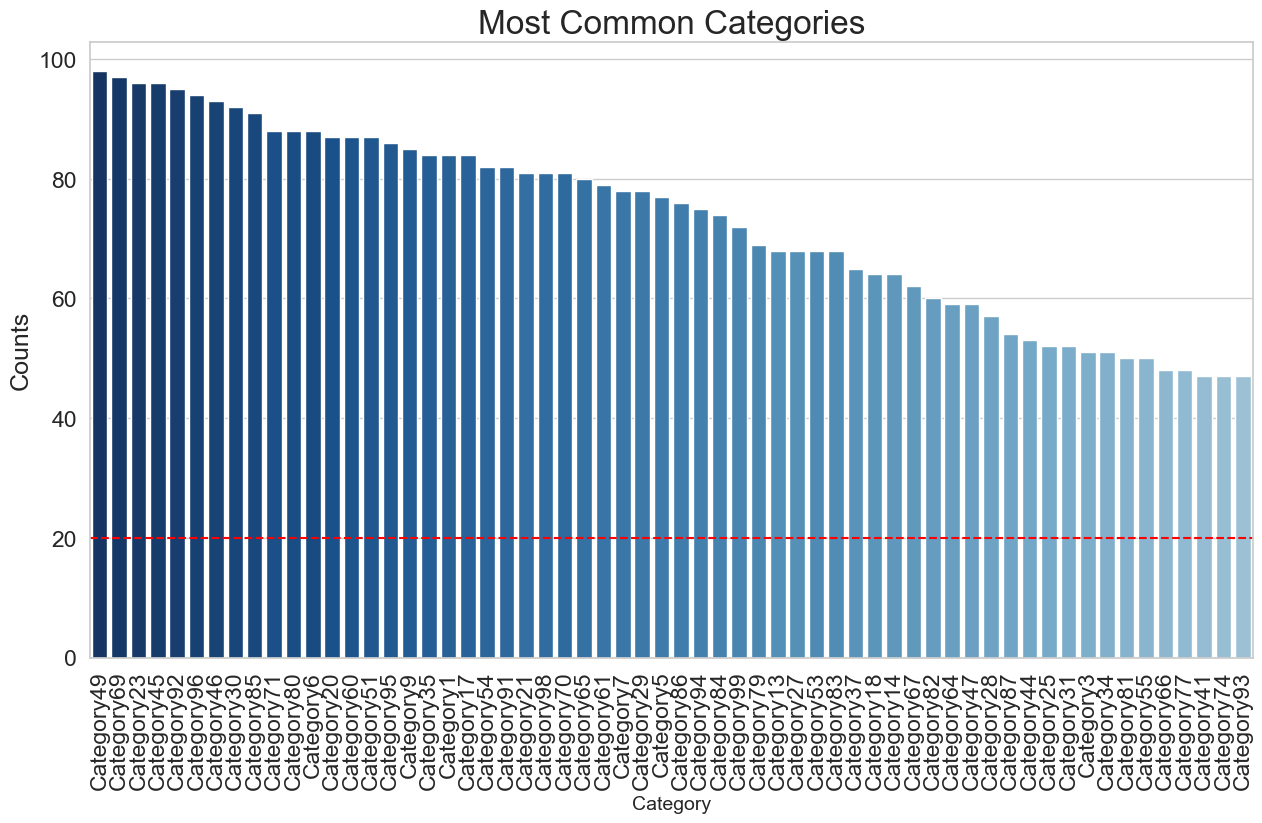

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example data for demonstration (replace this with your actual 'bar_plot' DataFrame)
data = {
    'category': [f'Category{i}' for i in range(1, 101)],
    'count': np.random.randint(1, 100, size=100)
}
bar_plot = pd.DataFrame(data)
bar_plot = bar_plot.sort_values(by='count', ascending=False)

# Set threshold
threshold = 20

# Plotting
plt.figure(figsize=(15, 8))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# Define the color palette and rank for coloring
pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

# Plotting the bar plot
sns.barplot(x=bar_plot['category'][:60], y=bar_plot['count'][:60], palette=np.array(pal[::-1])[rank][:60])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
# Uncomment the following line if you want to hide x-axis labels
# plt.xticks(color='w')

# Show plot
plt.show()


Now lets see the distribution of products along the number of categories they belongs to. for example product 1 may belong to 3 categories and product 10 may belong to just 1. Lets cumulate and see what this tells us!!

In [33]:
rowSums = df2.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()


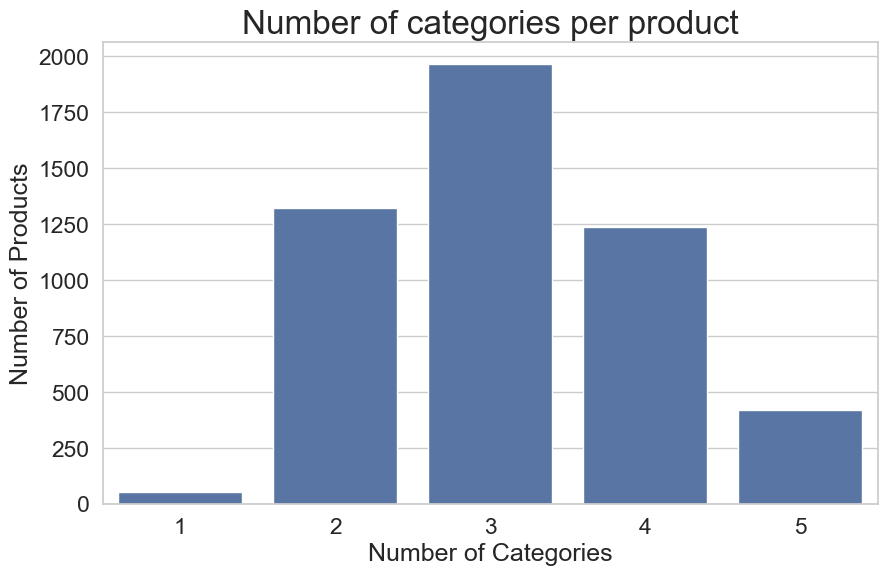

In [30]:
# Assuming multiLabel_counts is a pandas Series with indices as categories and values as counts

# Set the aesthetics
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# Initialize the figure
plt.figure(figsize=(10, 6))

# Plot the barplot with correct keyword arguments
sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

# Set plot title and labels
plt.title("Number of categories per product", fontsize=24)
plt.ylabel('Number of Products', fontsize=18)
plt.xlabel('Number of Categories', fontsize=18)

# Show the plot
plt.show()


Most products belong to 3 categories and almost all products have atleast 2 categories

In [34]:
boxplot = df2.copy()
boxplot['len'] = df2.description.apply(lambda x: len(x)) # length of descriptions

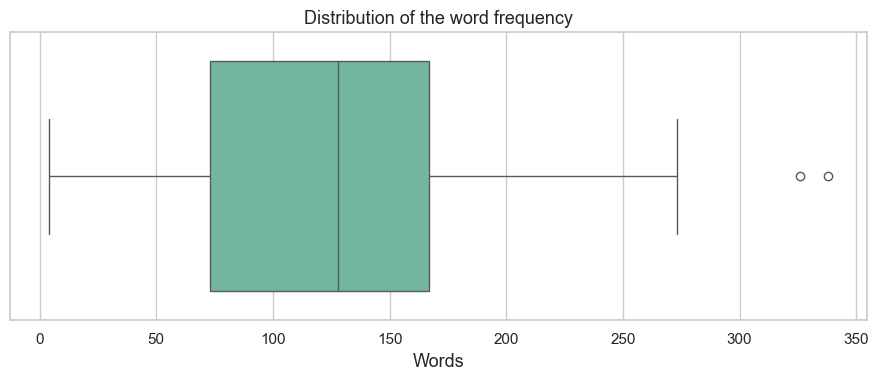

In [35]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})
plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

We can observe that most description's length range from 75 too 170 but there are few outliers till 340.

In [36]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence):
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [37]:
# Applying data cleaning on description to ignore irrelevant words
df2['description'] = df2['description'].str.lower()
df2['description'] = df2['description'].apply(decontract)
df2['description'] = df2['description'].apply(cleanPunc)
df2['description'] = df2['description'].apply(keepAlpha)
df2['description'] = df2['description'].apply(removeStopWords)
df2['description'] = df2['description'].apply(stemming)

In [38]:
# Applying data cleaning on product name to ignore irrelevant words
df2['name'] = df2['name'].str.lower()
df2['name'] = df2['name'].apply(decontract)
df2['name'] = df2['name'].apply(cleanPunc)
df2['name'] = df2['name'].apply(keepAlpha)
df2['name'] = df2['name'].apply(removeStopWords)
df2['name'] = df2['name'].apply(stemming)

In [39]:
# creating new column information which is concatenation of product name and description, which stores overall context about any product
df2["information"] = df2["name"] +" "+ df2["description"]
df2.head()

,name,description,Connected Home & Housewares,Car Electronics & GPS,Musical Instruments,"Toys, Games & Drones",Video Games,Cameras & Camcorders,Computers & Tablets,Appliances,...,HDMI Cables,Language Learning Software,Laptop Bags & Cases,Speaker Cables,Dehydrators,Dash Installation Kits,Deck Harnesses,Universal Camera Bags & Cases,Others,information
0,duracel aaa batteri pack,compat select electron devic aaa size duralock...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,duracel aaa batteri pack compat select electro...
1,duracel aa v coppertop batteri pack,longlast energi duralock power preserv technol...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,duracel aa v coppertop batteri pack longlast e...
2,duracel aa batteri pack,compat select electron devic aa size duralock ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,duracel aa batteri pack compat select electron...
3,energ max batteri aa pack,pack aa alkalin batteri batteri tester includ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,energ max batteri aa pack pack aa alkalin batt...
4,duracel c batteri pack,compat select electron devic c size duralock p...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,duracel c batteri pack compat select electron ...


# Deep Learning Based Model

Follows the Multi-class classification based model. Due to less time and api constraints i am not using llm based RAG system but it can be better fit to do this task.

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [55]:
tokenizer = Tokenizer(num_words=5000, lower=True) # lower : boolean. Whether to convert the texts to lowercase. , num_words : the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df2['information']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
sequences = tokenizer.texts_to_sequences(df2['information'])
x = pad_sequences(sequences, maxlen=500) # provide tagging to make each sequence of length 500

In [56]:
x.shape

(5000, 500)

In [57]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(x, df2[df2.columns[2:-1]],
                                                    test_size=0.3,
                                                    random_state=0)

In [58]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
most_common_cat.head()

,category,count,class_weight
0,Others,2232,0.060932
1,Video Games,1066,0.127580
2,Pre-Owned Games,899,0.151279
3,Appliances,850,0.160000
4,Musical Instruments,497,0.273642


In [59]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500

In [60]:
classes = [col for col in df2.columns]
classes = classes[2:-1]


## Conv Net Model

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the input layer
inputs = Input(shape=(maxlen,))

# Add embedding layer
x = Embedding(max_words, 100)(inputs)

# Add dropout layer
x = Dropout(0.2)(x)

# Add convolutional layer
x = Conv1D(100, 3, padding='valid', activation='relu', strides=1)(x)

# Add global max pooling layer
x = GlobalMaxPool1D()(x)

# Add another dropout layer
x = Dropout(0.2)(x)

# Add dense layer
x = Dense(num_classes)(x)

# Add activation layer
outputs = Activation('sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define callbacks
callbacks = [
    ReduceLROnPlateau(),
]

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 500, 100)       │       805,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 498, 100)       │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 136)            │        13,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 136)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,036 (3.24 MB)

 Trainable params: 849,036 (3.24 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [66]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - auc: 0.5761 - loss: 0.3873 - val_auc: 0.8128 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - auc: 0.7904 - loss: 0.0922 - val_auc: 0.8485 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - auc: 0.8422 - loss: 0.0781 - val_auc: 0.9043 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - auc: 0.8905 - loss: 0.0665 - val_auc: 0.9353 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - auc: 0.9270 - loss: 0.0573 - val_auc: 0.9590 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - auc: 0.9545 - loss: 0.0480 - val_auc: 0.9722 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - auc: 0.9686 - loss: 0.0418 - val_auc: 0.9802 - val_loss: 0.0410 - learning_rate: 0.0010

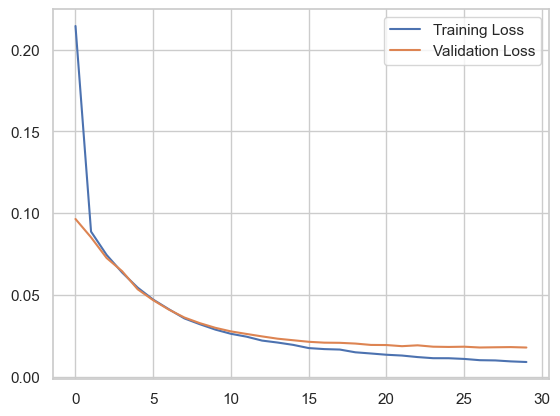

In [67]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [68]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9865 - loss: 0.0184
compile_metrics: 0.9860623478889465


# Lets Predict some products and their probability of belonging to a category

In [69]:
import operator
# Utility function to get predictions using Neural Net model
def predict_top_categories(name,description):
  # Data cleaning process
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description
  # necessary data preprocessing steps
  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=maxlen)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  return sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10] # return top 10 results

In [70]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = predict_top_categories(name,description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


[('Others', 0.60608566),
 ('Cell Phones', 0.12119913),
 ('Cell Phone Accessories', 0.06294417),
 ('Computers & Tablets', 0.008762129),
 ('Connected Home & Housewares', 0.007893937),
 ('Toys, Games & Drones', 0.007762395),
 ('Earbud & In-Ear Headphones', 0.005033926),
 ('iPhone Accessories', 0.0049523194),
 ('Audio', 0.0046271086),
 ('Recording Equipment', 0.00413196)]

In [71]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = predict_top_categories(name,description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[('Others', 0.8158294),
 ('TV & Home Theater', 0.096726544),
 ('Computers & Tablets', 0.063408524),
 ('TV Stands, Mounts & Furniture', 0.027845783),
 ('TV & Home Theater Accessories', 0.022805234),
 ('Cell Phones', 0.019029908),
 ('A/V Cables & Connectors', 0.01758951),
 ('Computer Accessories & Peripherals', 0.01705585),
 ('Cell Phone Accessories', 0.008191636),
 ('Connected Home', 0.007130578)]

In [72]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = predict_top_categories(name,description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[('Housewares', 0.89738274),
 ('Others', 0.8795102),
 ('Connected Home & Housewares', 0.83257854),
 ('Household Batteries', 0.80418193),
 ('Outdoor Living', 0.18382326),
 ('Audio', 0.08680001),
 ('Telephones & Communication', 0.0601549),
 ('Home Audio', 0.053582843),
 ('Small Kitchen Appliances', 0.037654232),
 ('Kitchen Gadgets', 0.024936497)]

In [73]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = predict_top_categories(name,description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[('Others', 0.89089876),
 ('Appliances', 0.7287595),
 ('Computers & Tablets', 0.2364111),
 ('Ranges, Cooktops & Ovens', 0.10913597),
 ('Heating, Cooling & Air Quality', 0.10190569),
 ('Vacuum & Floor Care Accessories', 0.08696171),
 ('Appliance Parts & Accessories', 0.08687358),
 ('Xbox 360 Games', 0.06591804),
 ('Freezers & Ice Makers', 0.06541255),
 ('Xbox 360', 0.064509585)]

In [74]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = predict_top_categories(name,description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[('Video Games', 0.99849683),
 ('Xbox 360', 0.8110411),
 ('Xbox 360 Games', 0.71624225),
 ('Nintendo DS', 0.20598318),
 ('Nintendo DS Games', 0.16956814),
 ('Others', 0.08688392),
 ('Pre-Owned Games', 0.076835215),
 ('Wii', 0.046199773),
 ('Appliances', 0.012233684),
 ('Car Lights & Lighting Accessories', 0.003282895)]